In [1]:
# - DQN (value-based) + A2C (actor-critic)
# - 2 reward functions (baseline + shaped_v2)
# - grid search (limited systematic)
# - evaluation protocol
# - multi-seed robustness
# - SHOW plots
# - RECORD + DISPLAY video for BOTH models 

# [1] Imports & Compatibility

In [2]:
import os
import time
import random
from dataclasses import dataclass
from collections import deque, namedtuple

import numpy as np

# NOTE: gym may reference np.bool8 in some versions
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

import gym

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def print_hardware():
    print("\n--- HARDWARE SETUP ---")
    print("Device:", DEVICE)
    if torch.cuda.is_available():
        print("CUDA name:", torch.cuda.get_device_name(0))
    else:
        print("CUDA: not available (CPU)")
    print("----------------------\n")

C:\Users\YILMAZ\AppData\Local\Temp\ipykernel_6624\3201762008.py:10: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, "bool8"):


Device: cpu


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
from IPython.display import Video, display # Notebook display helpers

# [2] Gym API Compatibility (robust)

In [4]:
def safe_reset(env, seed=None):
    out = env.reset(seed=seed) if seed is not None else env.reset()
    if isinstance(out, tuple):
        obs = out[0]
        info = out[1] if len(out) >= 2 and isinstance(out[1], dict) else {}
        return obs, info
    return out, {}

def safe_step(env, action):
    out = env.step(action)
    if not isinstance(out, tuple):
        raise ValueError(f"Unexpected step output: {out}")

    # New api: obs, reward, terminated, truncated, info
    if len(out) == 5:
        obs, reward, terminated, truncated, info = out
        done = bool(terminated or truncated)
        return obs, float(reward), done, info

    # Old api: obs, reward, done, info
    if len(out) == 4:
        obs, reward, done, info = out
        return obs, float(reward), bool(done), info

    raise ValueError(f"Unexpected step tuple length {len(out)}: {out}")

- To ensure compatibility between different Gym/Gymnasium API versions and to standardize environment outputs, we implemented the safe_reset and safe_step wrappers.

# [3] Reward Shaping + Env

In [5]:
def reward_baseline(obs, env_reward):
    return float(env_reward)

def reward_shaped_v2(obs, env_reward, c=2.0):
    pole_angle = float(obs[2])  # CartPole: obs[2] is pole angle
    return float(1.0 - c * abs(pole_angle))

def make_env(env_id: str, seed: int, render_mode=None):
    env = gym.make(env_id, render_mode=render_mode) if render_mode is not None else gym.make(env_id)
    try:
        env.action_space.seed(seed)
    except Exception:
        pass
    return env

def get_reward_fn(reward_name: str, shaped_c: float = 2.0):
    if reward_name == "baseline":
        return lambda obs, r: reward_baseline(obs, r)
    if reward_name == "shaped_v2":
        return lambda obs, r: reward_shaped_v2(obs, r, c=shaped_c)
    raise ValueError("reward_name must be 'baseline' or 'shaped_v2'")

- In the baseline approach, the reward provided by the Gym environment is used without any modification.  This reward serves as a reference point for comparison.

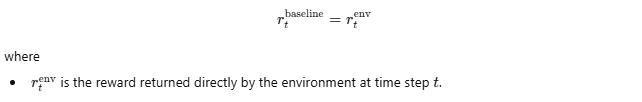

- In the shaped reward version, the reward is computed based on the pole angle in the CartPole environment. The pole angle is given by the third element of the observation vector, obs[2].

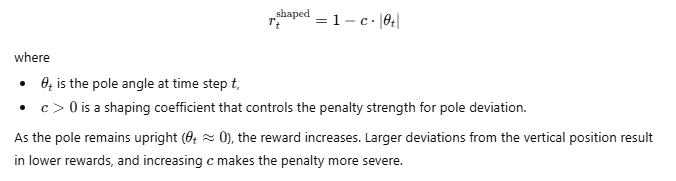

- The environment is initialized with an optional random seed to ensure reproducibility, allowing experiments to be repeated under identical stochastic conditions.

- The reward function is selected dynamically based on the specified reward_name, enabling seamless switching between baseline and shaped rewards without modifying the training loop.

# [4] DQN

In [6]:
Experience = namedtuple("Experience", ["state", "action", "reward", "next_state", "done"])

class QNetwork(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden1=128, hidden2=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, action_dim),
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity: int, batch_size: int, device: torch.device):
        self.memory = deque(maxlen=capacity)
        self.batch_size = batch_size
        self.device = device

    def add(self, state, action, reward, next_state, done):
        self.memory.append(Experience(state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.memory, k=self.batch_size)
        states = torch.tensor(np.vstack([e.state for e in batch]), dtype=torch.float32, device=self.device)
        actions = torch.tensor(np.vstack([e.action for e in batch]), dtype=torch.int64, device=self.device)
        rewards = torch.tensor(np.vstack([e.reward for e in batch]), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.vstack([e.next_state for e in batch]), dtype=torch.float32, device=self.device)
        dones = torch.tensor(np.vstack([e.done for e in batch]).astype(np.uint8), dtype=torch.float32, device=self.device)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

@dataclass
class DQNConfig:
    gamma: float = 0.99
    lr: float = 5e-4
    batch_size: int = 64
    buffer_size: int = 100_000

    learning_starts: int = 1000
    train_every: int = 1
    gradient_steps: int = 1
    target_update_every: int = 1000
    double_dqn: bool = True

    grad_clip_norm: float = 10.0

class DQNAgent:
    def __init__(self, state_dim: int, action_dim: int, seed: int, cfg: DQNConfig, device: torch.device):
        set_seed(seed)
        self.cfg = cfg
        self.device = device
        self.action_dim = action_dim

        self.q_local = QNetwork(state_dim, action_dim).to(device)
        self.q_target = QNetwork(state_dim, action_dim).to(device)
        self.q_target.load_state_dict(self.q_local.state_dict())
        self.q_target.eval()

        self.optimizer = optim.Adam(self.q_local.parameters(), lr=cfg.lr)
        self.replay = ReplayBuffer(cfg.buffer_size, cfg.batch_size, device)

        self.env_steps = 0

    @torch.no_grad()
    def act(self, state: np.ndarray, eps: float) -> int:
        if random.random() < eps:
            return random.randrange(self.action_dim)
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        q = self.q_local(s)
        return int(torch.argmax(q, dim=1).item())

    def store(self, state, action, reward, next_state, done):
        self.replay.add(state, action, reward, next_state, done)

    def maybe_learn(self):
        self.env_steps += 1

        if self.env_steps % self.cfg.target_update_every == 0:
            self.q_target.load_state_dict(self.q_local.state_dict())

        if len(self.replay) < self.cfg.learning_starts:
            return None

        if self.env_steps % self.cfg.train_every != 0:
            return None

        losses = []
        for _ in range(self.cfg.gradient_steps):
            experiences = self.replay.sample()
            loss = self.learn(experiences)
            losses.append(loss)

        return float(np.mean(losses))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        with torch.no_grad():
            if self.cfg.double_dqn:
                next_actions = torch.argmax(self.q_local(next_states), dim=1, keepdim=True)
                q_next = self.q_target(next_states).gather(1, next_actions)
            else:
                q_next = self.q_target(next_states).max(dim=1, keepdim=True)[0]

            q_target = rewards + (self.cfg.gamma * q_next * (1.0 - dones))

        q_expected = self.q_local(states).gather(1, actions)
        loss = F.mse_loss(q_expected, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_local.parameters(), self.cfg.grad_clip_norm)
        self.optimizer.step()

        return float(loss.item())

- A modular Deep Q-Network (DQN) agent with experience repetition and target network was implemented. Optional Dual DQN support is also available. The agent learns an approximate action-value function using a neural network and provides stable and repeatable training by updating its parameters based on passes sampled from the repetition buffer.

# [5] A2C (Advantage Actor-Critic)

In [7]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden: int = 128):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(state_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )
        self.policy_head = nn.Linear(hidden, action_dim)
        self.value_head  = nn.Linear(hidden, 1)

    def forward(self, x):
        h = self.body(x)
        logits = self.policy_head(h)
        value  = self.value_head(h)
        return logits, value

@dataclass
class A2CConfig:
    gamma: float = 0.99
    lr: float = 5e-4
    hidden: int = 128

    n_steps: int = 5
    entropy_coef: float = 0.01
    value_coef: float = 0.5
    grad_clip_norm: float = 10.0

class A2CAgent:
    def __init__(self, state_dim: int, action_dim: int, seed: int, cfg: A2CConfig, device: torch.device):
        set_seed(seed)
        self.cfg = cfg
        self.device = device
        self.model = ActorCritic(state_dim, action_dim, hidden=cfg.hidden).to(device)
        self.opt = optim.Adam(self.model.parameters(), lr=cfg.lr)

    @torch.no_grad()
    def act(self, state: np.ndarray):
        s = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        logits, value = self.model(s)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        logp = dist.log_prob(action).squeeze(0)
        entropy = dist.entropy().squeeze(0)
        return int(action.item()), logp, entropy, value.squeeze(0).squeeze(0)

    def update_from_rollout(self, rollout):
        states = rollout["states"]
        actions = rollout["actions"]
        rewards = rollout["rewards"]
        dones = rollout["dones"]
        next_state = rollout["next_state"]
        last_done = rollout["last_done"]

        logits, values = self.model(states)
        values = values.squeeze(-1)
        dist = torch.distributions.Categorical(logits=logits)
        logps = dist.log_prob(actions)
        entropies = dist.entropy()

        with torch.no_grad():
            if last_done:
                v_boot = torch.tensor(0.0, device=self.device)
            else:
                ns = torch.tensor(next_state, dtype=torch.float32, device=self.device).unsqueeze(0)
                _, v_next = self.model(ns)
                v_boot = v_next.squeeze(0).squeeze(0)

        returns = torch.zeros_like(rewards, device=self.device)
        G = v_boot
        for t in reversed(range(len(rewards))):
            G = rewards[t] + self.cfg.gamma * G * (1.0 - dones[t])
            returns[t] = G

        advantages = returns - values

        policy_loss = -(logps * advantages.detach()).mean()
        value_loss = F.mse_loss(values, returns.detach())
        entropy_loss = -entropies.mean()

        loss = policy_loss + self.cfg.value_coef * value_loss + self.cfg.entropy_coef * entropy_loss

        self.opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.grad_clip_norm)
        self.opt.step()

        return float(loss.item())

- The Advantage Actor–Critic (A2C) algorithm is implemented. The Actor and Critic share a common neural network body, where the policy head outputs action probabilities and the value head estimates the state value function. The agent collects n-step rollouts and computes bootstrapped returns to obtain advantage estimates. During training, the policy loss, value function loss, and an entropy term that encourages exploration are jointly optimized, while gradient clipping is applied to stabilize the learning process.

# [6] Plot utilities 

In [8]:
def plot_curve_show(scores, title, ma_window=25, show=True):
    if not show:
        return
    scores = np.asarray(scores, dtype=float)

    plt.figure()
    plt.plot(scores, alpha=0.35, label="Episode return")

    if len(scores) >= ma_window:
        ma = np.convolve(scores, np.ones(ma_window) / ma_window, mode="valid")
        plt.plot(np.arange(len(ma)) + (ma_window - 1), ma, label=f"Moving Avg ({ma_window})")

    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Episode Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def moving_average(x, window=25):
    x = np.asarray(x, dtype=float)
    if len(x) < window:
        return x
    kernel = np.ones(window) / window
    return np.convolve(x, kernel, mode="valid")

def plot_mean_std_band_show(all_scores, title, ma_window=25, show=True):
    if not show:
        return
    min_len = min(len(s) for s in all_scores)
    data = np.array([s[:min_len] for s in all_scores], dtype=float)

    mean_curve = data.mean(axis=0)
    std_curve  = data.std(axis=0)

    mean_ma = moving_average(mean_curve, ma_window)
    std_ma  = moving_average(std_curve, ma_window)

    x = np.arange(len(mean_ma))

    plt.figure()
    plt.plot(x, mean_ma, label="Mean (moving avg)")
    plt.fill_between(x, mean_ma - std_ma, mean_ma + std_ma, alpha=0.2, label="±1 std (moving avg)")
    plt.title(title)
    plt.xlabel("Episode (smoothed)")
    plt.ylabel("Episode Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# [7] Training loops 

In [9]:
# show_plot flag to display learning curve right after training

def train_dqn(
    env_id="CartPole-v1",
    seed=170715,
    reward_name="baseline",
    num_episodes=500,
    max_steps=500,
    eps_start=1.0,
    eps_end=0.01,
    eps_decay=0.995,
    cfg=DQNConfig(),
    shaped_c=2.0,
    verbose_every=10,
    show_plot=False,   
):
    env = make_env(env_id, seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = DQNAgent(state_dim, action_dim, seed, cfg, DEVICE)

    reward_fn = get_reward_fn(reward_name, shaped_c=shaped_c)

    scores = []
    window = deque(maxlen=100)
    eps = eps_start
    t0 = time.time()

    for ep in range(1, num_episodes + 1):
        state, _ = safe_reset(env, seed=seed + ep)
        total = 0.0

        for _ in range(max_steps):
            action = agent.act(state, eps)
            next_state, env_reward, done, _ = safe_step(env, action)
            reward = reward_fn(next_state, env_reward)

            agent.store(state, action, reward, next_state, done)
            agent.maybe_learn()

            state = next_state
            total += reward
            if done:
                break

        scores.append(total)
        window.append(total)
        eps = max(eps_end, eps * eps_decay)

        if (verbose_every is not None) and (ep % verbose_every == 0):
            print(f"[DQN | {reward_name}] Ep {ep:4d} | Avg100: {np.mean(window):7.2f} | eps: {eps:6.3f}")

    env.close()
    elapsed = time.time() - t0

    # SHOW learning curve in notebook 
    plot_curve_show(scores, title=f"DQN | {reward_name} | train={num_episodes}", show=show_plot)

    return agent, scores, elapsed


def train_a2c(
    env_id="CartPole-v1",
    seed=170715,
    reward_name="baseline",
    num_episodes=600,
    max_steps=500,
    cfg=A2CConfig(),
    shaped_c=2.0,
    verbose_every=10,
    show_plot=False,   
):
    env = make_env(env_id, seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = A2CAgent(state_dim, action_dim, seed, cfg, DEVICE)

    reward_fn = get_reward_fn(reward_name, shaped_c=shaped_c)

    scores = []
    window = deque(maxlen=100)
    t0 = time.time()

    for ep in range(1, num_episodes + 1):
        state, _ = safe_reset(env, seed=seed + ep)
        total = 0.0

        buf_states, buf_actions, buf_rewards, buf_dones = [], [], [], []

        for _ in range(max_steps):
            action, logp, entropy, value = agent.act(state)
            next_state, env_reward, done, _ = safe_step(env, action)
            reward = reward_fn(next_state, env_reward)

            buf_states.append(state)
            buf_actions.append(action)
            buf_rewards.append(reward)
            buf_dones.append(float(done))

            total += reward
            state = next_state

            if (len(buf_rewards) >= cfg.n_steps) or done:
                rollout = {
                    "states": torch.tensor(np.array(buf_states), dtype=torch.float32, device=DEVICE),
                    "actions": torch.tensor(np.array(buf_actions), dtype=torch.int64, device=DEVICE),
                    "rewards": torch.tensor(np.array(buf_rewards), dtype=torch.float32, device=DEVICE),
                    "dones": torch.tensor(np.array(buf_dones), dtype=torch.float32, device=DEVICE),
                    "next_state": state,
                    "last_done": bool(done),
                }
                agent.update_from_rollout(rollout)
                buf_states.clear(); buf_actions.clear(); buf_rewards.clear(); buf_dones.clear()

            if done:
                break

        scores.append(total)
        window.append(total)

        if (verbose_every is not None) and (ep % verbose_every == 0):
            print(f"[A2C | {reward_name}] Ep {ep:4d} | Avg100: {np.mean(window):7.2f}")

    env.close()
    elapsed = time.time() - t0

    # learning curve in notebook 
    plot_curve_show(scores, title=f"A2C | {reward_name} | train={num_episodes}", show=show_plot)

    return agent, scores, elapsed

- The train_dqn function trains a Deep Q-Network (DQN) agent using an ε-greedy exploration strategy. In each episode, the agent interacts with the environment, stores experiences in a replay buffer, updates the network when appropriate, and gradually decreases ε to shift from exploration to exploitation. Episode returns are recorded, the average performance over the last 100 episodes is periodically reported, and the learning curve is visualized.

- The train_a2c function trains an Advantage Actor–Critic (A2C) agent. The agent collects n-step rollouts and jointly updates the policy and value networks by computing bootstrapped returns and advantage estimates. Throughout training, episode returns are tracked, performance is periodically reported, and the learning curve is visualized.

# [8] Evaluation (IN-MEMORY)

In [10]:
@torch.no_grad()
def evaluate_agent_dqn(agent: DQNAgent, reward_name="baseline", env_id="CartPole-v1",
                       episodes=100, seed=2025, shaped_c=2.0):
    env = make_env(env_id, seed)
    reward_fn = get_reward_fn(reward_name, shaped_c=shaped_c)

    returns = []
    for ep in range(episodes):
        state, _ = safe_reset(env, seed=seed + ep)
        total = 0.0
        done = False
        while not done:
            s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            q = agent.q_local(s)
            action = int(torch.argmax(q, dim=1).item())
            next_state, env_reward, done, _ = safe_step(env, action)
            total += reward_fn(next_state, env_reward)
            state = next_state
        returns.append(total)

    env.close()
    mean_r = float(np.mean(returns))
    std_r  = float(np.std(returns))
    solved = mean_r >= 475
    return mean_r, std_r, returns, solved

@torch.no_grad()
def evaluate_agent_a2c(agent: A2CAgent, reward_name="baseline", env_id="CartPole-v1",
                       episodes=100, seed=2025, shaped_c=2.0, eval_mode="greedy"):
    if eval_mode not in ["greedy", "stochastic"]:
        raise ValueError("eval_mode must be 'greedy' or 'stochastic'")

    env = make_env(env_id, seed)
    reward_fn = get_reward_fn(reward_name, shaped_c=shaped_c)

    returns = []
    for ep in range(episodes):
        state, _ = safe_reset(env, seed=seed + ep)
        total = 0.0
        done = False
        while not done:
            s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            logits, _ = agent.model(s)

            if eval_mode == "greedy":
                action = int(torch.argmax(logits, dim=1).item())
            else:
                dist = torch.distributions.Categorical(logits=logits)
                action = int(dist.sample().item())

            next_state, env_reward, done, _ = safe_step(env, action)
            total += reward_fn(next_state, env_reward)
            state = next_state
        returns.append(total)

    env.close()
    mean_r = float(np.mean(returns))
    std_r  = float(np.std(returns))
    solved = mean_r >= 475
    return mean_r, std_r, returns, solved

The trained DQN and A2C agents are evaluated without further learning.The evaluation is performed using fixed policies to measure the true performance of each agent.

- **DQN Evaluation:**  
  The DQN agent is evaluated using a greedy policy by selecting the action with the
  highest Q-value at each state. Episode returns are collected over multiple episodes,
  and the mean and standard deviation of returns are reported.

- **A2C Evaluation:**  
  The A2C agent is evaluated either in greedy mode (selecting the action with the highest
  policy logit) or in stochastic mode (sampling from the policy distribution). Episode
  returns are recorded, and the mean and standard deviation are computed.

An environment is considered solved if the average return over the evaluation episodes exceeds 475(treshold).

# [9] Video recording

In [11]:
from gym.wrappers import RecordVideo

@torch.no_grad()
def record_video_dqn(agent: DQNAgent, env_id="CartPole-v1", seed=42, max_steps=500,
                     out_dir="videos", prefix="dqn", fps=None):
    os.makedirs(out_dir, exist_ok=True)

    env = make_env(env_id, seed, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=out_dir, episode_trigger=lambda ep: ep == 0, name_prefix=prefix)

    state, _ = safe_reset(env, seed=seed)
    for _ in range(max_steps):
        s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        q = agent.q_local(s)
        action = int(torch.argmax(q, dim=1).item())
        state, _, done, _ = safe_step(env, action)
        if done:
            break

    env.close()

    mp4s = [f for f in os.listdir(out_dir) if f.endswith(".mp4") and f.startswith(prefix)]
    mp4s.sort()
    if not mp4s:
        print("No mp4 found in", out_dir)
        return None
    return os.path.join(out_dir, mp4s[-1])

@torch.no_grad()
def record_video_a2c(agent: A2CAgent, env_id="CartPole-v1", seed=42, max_steps=500,
                     out_dir="videos", prefix="a2c", eval_mode="greedy"):
    os.makedirs(out_dir, exist_ok=True)

    env = make_env(env_id, seed, render_mode="rgb_array")
    env = RecordVideo(env, video_folder=out_dir, episode_trigger=lambda ep: ep == 0, name_prefix=prefix)

    state, _ = safe_reset(env, seed=seed)
    for _ in range(max_steps):
        s = torch.tensor(state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        logits, _ = agent.model(s)
        if eval_mode == "greedy":
            action = int(torch.argmax(logits, dim=1).item())
        else:
            dist = torch.distributions.Categorical(logits=logits)
            action = int(dist.sample().item())
        state, _, done, _ = safe_step(env, action)
        if done:
            break

    env.close()

    mp4s = [f for f in os.listdir(out_dir) if f.endswith(".mp4") and f.startswith(prefix)]
    mp4s.sort()
    if not mp4s:
        print("No mp4 found in", out_dir)
        return None
    return os.path.join(out_dir, mp4s[-1])

# [10] One-call runner (PRINTS + PLOT + VIDEO)

In [12]:
def run_experiment(
    model_name=None,
    reward_name="baseline",
    seed=170715,
    train_episodes=None,
    eval_episodes=100,
    show_plot=False,     
    shaped_c=2.0,
    algo=None,           # alias
    record_video=False,  
    video_dir="videos",  
    video_seed=123,      
):
    if model_name is None and algo is not None:
        model_name = algo
    if model_name is None:
        raise ValueError("Provide model_name='dqn'/'a2c' (or algo='dqn'/'a2c').")

    model_name = str(model_name).lower().strip()

    print("\n" + "="*80)
    print(f"RUN EXPERIMENT | Model={model_name.upper()} | Reward={reward_name}")
    print("="*80)

    video_path = None

    if model_name == "dqn":
        if train_episodes is None:
            train_episodes = 500
        agent, scores, elapsed = train_dqn(
            seed=seed,
            reward_name=reward_name,
            num_episodes=train_episodes,
            cfg=DQNConfig(),
            shaped_c=shaped_c,
            show_plot=show_plot,     
        )
        mean_r, std_r, _, solved = evaluate_agent_dqn(
            agent, reward_name=reward_name, episodes=eval_episodes, seed=2025, shaped_c=shaped_c
        )

        if record_video:
            video_path = record_video_dqn(
                agent, seed=video_seed, out_dir=video_dir,
                prefix=f"dqn_{reward_name}"
            )

    elif model_name == "a2c":
        if train_episodes is None:
            train_episodes = 600
        agent, scores, elapsed = train_a2c(
            seed=seed,
            reward_name=reward_name,
            num_episodes=train_episodes,
            cfg=A2CConfig(),
            shaped_c=shaped_c,
            show_plot=show_plot,     
        )
        mean_r, std_r, _, solved = evaluate_agent_a2c(
            agent, reward_name=reward_name, episodes=eval_episodes, seed=2025, shaped_c=shaped_c, eval_mode="greedy"
        )

        if record_video:
            video_path = record_video_a2c(
                agent, seed=video_seed, out_dir=video_dir,
                prefix=f"a2c_{reward_name}",
                eval_mode="greedy"
            )

    else:
        raise ValueError("model_name (or algo) must be 'dqn' or 'a2c'")

    print("\n--- TRAINING ---")
    print(f"Train episodes: {train_episodes}")
    print(f"Train time   : {elapsed/60:.2f} minutes")

    print("\n--- EVALUATION ---")
    print(f"Eval episodes: {eval_episodes}")
    print(f"Mean return : {mean_r:.2f}")
    print(f"Std return  : {std_r:.2f}")
    print(f"Solved?     : {'YES' if solved else 'NO'} (threshold >= 475)")

    if record_video:
        print("\n--- VIDEO ---")
        print("Saved to:", video_path)
        if video_path is not None:
            display(Video(video_path, embed=True))

    print("="*80)

    return agent, {
        "model": model_name,
        "reward": reward_name,
        "train_episodes": train_episodes,
        "eval_episodes": eval_episodes,
        "eval_mean": mean_r,
        "eval_std": std_r,
        "solved": solved,
        "train_minutes": elapsed / 60.0,
        "video_path": video_path,
    }

- This function provides a unified pipeline to run reinforcement learning experiments using either DQN or A2C on the CartPole-v1 environment. Based on the selected algorithm, the agent is trained for a predefined number of episodes and then evaluated over multiple test episodes using a fixed policy.

- The function reports training time, mean and standard deviation of evaluation returns,and determines whether the environment is considered solved (average return ≥ 475). Optionally, the trained agent’s behavior can be recorded as a video for qualitative inspection. All results are summarized and returned in a structured dictionary to facilitate comparison across different experiments and reward settings.

# [11] Grid Search

In [13]:
def _format_params_short(params: dict):
    return ", ".join([f"{k}={v}" for k, v in params.items()])

def grid_search(
    model_name="dqn",
    reward_name="baseline",
    seed=170715,
    train_episodes=250,
    eval_episodes=50,
    param_grid=None,
    shaped_c=2.0,
    top_k_print=5,
    algo=None,
    show_best_plot=False,     
):
    if algo is not None:
        model_name = algo
    model_name = str(model_name).lower().strip()

    if model_name not in ["dqn", "a2c"]:
        raise ValueError("model_name must be 'dqn' or 'a2c' (or use algo='dqn'/'a2c').")

    print("\n" + "="*80)
    print(f"GRID SEARCH | Model={model_name.upper()} | Reward={reward_name}")
    print("="*80)

    results = []

    if model_name == "dqn":
        if param_grid is None:
            param_grid = {
                "lr": [1e-4, 5e-4, 1e-3],
                "gamma": [0.95, 0.99],
                "target_update_every": [500, 1000],
            }

        keys = list(param_grid.keys())

        def rec_build(i, curr):
            if i == len(keys):
                yield dict(curr)
                return
            k = keys[i]
            for v in param_grid[k]:
                curr[k] = v
                yield from rec_build(i + 1, curr)

        combos = list(rec_build(0, {}))

        for idx, params in enumerate(combos, 1):
            cfg = DQNConfig(
                lr=float(params.get("lr", 5e-4)),
                gamma=float(params.get("gamma", 0.99)),
                target_update_every=int(params.get("target_update_every", 1000)),
                batch_size=64,
                buffer_size=100_000,
                learning_starts=1000,
                train_every=1,
                gradient_steps=1,
                double_dqn=True,
            )

            print("\n" + "-"*80)
            print(f"GRID {idx}/{len(combos)} | DQN | {_format_params_short(params)}")
            print("-"*80)

            agent, scores, elapsed = train_dqn(
                seed=seed,
                reward_name=reward_name,
                num_episodes=train_episodes,
                cfg=cfg,
                shaped_c=shaped_c,
                verbose_every=None,
                show_plot=False,   # keep grid quiet; show best later
            )

            mean_r, std_r, _, solved = evaluate_agent_dqn(
                agent, reward_name=reward_name, episodes=eval_episodes, seed=10_000 + idx, shaped_c=shaped_c
            )

            results.append({
                "mean_reward": mean_r,
                "std_reward": std_r,
                "solved": solved,
                "params": params,
                "train_minutes": elapsed / 60.0,
                "scores": scores,
                "agent": agent,
            })

            print(f"Eval mean={mean_r:.2f} | std={std_r:.2f} | solved={solved} | train_min={elapsed/60:.2f}")

    else:  # a2c
        if param_grid is None:
            param_grid = {
                "lr": [1e-3, 5e-4, 2e-4],
                "gamma": [0.97, 0.99],
                "hidden": [64, 128],
                "n_steps": [5, 10],
                "entropy_coef": [0.0, 0.01],
            }

        keys = list(param_grid.keys())

        def rec_build(i, curr):
            if i == len(keys):
                yield dict(curr)
                return
            k = keys[i]
            for v in param_grid[k]:
                curr[k] = v
                yield from rec_build(i + 1, curr)

        combos = list(rec_build(0, {}))

        for idx, params in enumerate(combos, 1):
            cfg = A2CConfig(
                lr=float(params.get("lr", 5e-4)),
                gamma=float(params.get("gamma", 0.99)),
                hidden=int(params.get("hidden", 128)),
                n_steps=int(params.get("n_steps", 5)),
                entropy_coef=float(params.get("entropy_coef", 0.01)),
                value_coef=0.5,
            )

            print("\n" + "-"*80)
            print(f"GRID {idx}/{len(combos)} | A2C | {_format_params_short(params)}")
            print("-"*80)

            agent, scores, elapsed = train_a2c(
                seed=seed,
                reward_name=reward_name,
                num_episodes=train_episodes,
                cfg=cfg,
                shaped_c=shaped_c,
                verbose_every=None,
                show_plot=False,
            )

            mean_r, std_r, _, solved = evaluate_agent_a2c(
                agent, reward_name=reward_name, episodes=eval_episodes, seed=20_000 + idx,
                shaped_c=shaped_c, eval_mode="greedy"
            )

            results.append({
                "mean_reward": mean_r,
                "std_reward": std_r,
                "solved": solved,
                "params": params,
                "train_minutes": elapsed / 60.0,
                "scores": scores,
                "agent": agent,
            })

            print(f"Eval mean={mean_r:.2f} | std={std_r:.2f} | solved={solved} | train_min={elapsed/60:.2f}")

    results.sort(key=lambda d: d["mean_reward"], reverse=True)
    best = results[0]

    print("\n" + "="*80)
    print("GRID SEARCH DONE (sorted by eval mean)")
    print("="*80)
    print(f"BEST | mean={best['mean_reward']:.2f} std={best['std_reward']:.2f} solved={best['solved']}")
    print("params:", best["params"])
    print("-" * 80)

    k = min(top_k_print, len(results))
    print(f"\nTOP-{k} CONFIGS:")
    for i in range(k):
        r = results[i]
        print(f"{i+1:2d}) mean={r['mean_reward']:.2f} std={r['std_reward']:.2f} solved={r['solved']} | params={r['params']}")

    # show best config training curve 
    if show_best_plot:
        plot_curve_show(best["scores"], title=f"BEST {model_name.upper()} | {reward_name}", show=True)

    return results

This function performs a systematic hyperparameter grid search for DQN and A2C agents under a fixed environment and reward configuration. For each algorithm, a set of candidate hyperparameters is defined and all possible parameter combinations are evaluated.

Each configuration is trained for a fixed number of episodes and subsequently evaluated over multiple test episodes using a deterministic (greedy) policy. The mean and standard deviation of episode returns, training time, and whether the environment is considered solved are recorded for each run.

All configurations are ranked according to their evaluation mean return, and the best performing hyperparameter set is reported along with the top-k configurations. Optionally, the learning curve of the best configuration can be visualized to analyze training dynamics and stability.

This procedure enables a fair and reproducible comparison of different hyperparameter choices and their impact on agent performance.

# [12] Multi-seed evaluation

In [14]:
def run_best_configs_3seeds_report(
    reward_name="shaped_v2",
    seeds=(0, 1, 2),
    train_episodes=400,
    eval_episodes=100,
    dqn_best_cfg=None,
    a2c_best_cfg=None,
    shaped_c=2.0,
    show_band_plot=False,
):
    print("\n" + "="*80)
    print("MULTI-SEED REPORT | Best Configs | 3 Seeds")
    print("="*80)
    print(f"Reward function: {reward_name}")
    print(f"Seeds         : {list(seeds)}")
    print(f"Train episodes: {train_episodes}")
    print(f"Eval episodes : {eval_episodes}")
    print("="*80)

    if dqn_best_cfg is None:
        dqn_best_cfg = DQNConfig(lr=5e-4, gamma=0.95, target_update_every=1000)

    if a2c_best_cfg is None:
        a2c_best_cfg = A2CConfig(lr=1e-3, gamma=0.97, hidden=128, n_steps=10, entropy_coef=0.0)

    dqn_eval_means = []
    a2c_greedy_means = []
    a2c_stoch_means = []

    dqn_train_curves = []
    a2c_train_curves = []

    for s in seeds:
        print("\n" + "-"*80)
        print(f"SEED RUN: {s}")
        print("-"*80)

        dqn_agent, dqn_scores, _ = train_dqn(
            seed=s, reward_name=reward_name, num_episodes=train_episodes, cfg=dqn_best_cfg,
            shaped_c=shaped_c, verbose_every=None, show_plot=False
        )
        dqn_train_curves.append(dqn_scores)
        mean_r, std_r, _, solved = evaluate_agent_dqn(
            dqn_agent, reward_name=reward_name, episodes=eval_episodes, seed=10_000 + s, shaped_c=shaped_c
        )
        dqn_eval_means.append(mean_r)
        print(f"[Eval] DQN | mean={mean_r:.2f} std={std_r:.2f} | solved={solved}")

        a2c_agent, a2c_scores, _ = train_a2c(
            seed=s, reward_name=reward_name, num_episodes=train_episodes, cfg=a2c_best_cfg,
            shaped_c=shaped_c, verbose_every=None, show_plot=False
        )
        a2c_train_curves.append(a2c_scores)

        mean_g, std_g, _, solved_g = evaluate_agent_a2c(
            a2c_agent, reward_name=reward_name, episodes=eval_episodes, seed=20_000 + s,
            shaped_c=shaped_c, eval_mode="greedy"
        )
        mean_s, std_s, _, solved_s = evaluate_agent_a2c(
            a2c_agent, reward_name=reward_name, episodes=eval_episodes, seed=30_000 + s,
            shaped_c=shaped_c, eval_mode="stochastic"
        )

        a2c_greedy_means.append(mean_g)
        a2c_stoch_means.append(mean_s)

        print(f"[Eval] A2C greedy     | mean={mean_g:.2f} std={std_g:.2f} | solved={solved_g}")
        print(f"[Eval] A2C stochastic | mean={mean_s:.2f} std={std_s:.2f} | solved={solved_s}")

    def agg(x):
        return float(np.mean(x)), float(np.std(x))

    dqn_mean, dqn_std = agg(dqn_eval_means)
    a2c_g_mean, a2c_g_std = agg(a2c_greedy_means)
    a2c_s_mean, a2c_s_std = agg(a2c_stoch_means)

    print("\n" + "="*80)
    print("FINAL SUMMARY (across seeds)")
    print("="*80)
    print(f"DQN | eval mean over seeds: {dqn_mean:.2f} ± {dqn_std:.2f}")
    print(f"A2C | greedy mean over seeds: {a2c_g_mean:.2f} ± {a2c_g_std:.2f}")
    print(f"A2C | stochastic mean over seeds: {a2c_s_mean:.2f} ± {a2c_s_std:.2f}")
    print("="*80)

    if show_band_plot:
        plot_mean_std_band_show(dqn_train_curves, title=f"DQN | {reward_name} | 3 seeds mean±std", show=True)
        plot_mean_std_band_show(a2c_train_curves, title=f"A2C | {reward_name} | 3 seeds mean±std", show=True)

    return {
        "dqn_eval_means": dqn_eval_means,
        "a2c_greedy_means": a2c_greedy_means,
        "a2c_stoch_means": a2c_stoch_means,
        "dqn_train_curves": dqn_train_curves,
        "a2c_train_curves": a2c_train_curves,
        "dqn_best_cfg": dqn_best_cfg,
        "a2c_best_cfg": a2c_best_cfg,
    }

This experiment evaluates the robustness of the best-performing DQN and A2C hyperparameter configurations across multiple random seeds. Using a fixed reward function, each agent is trained and evaluated independently for three different seeds to assess performance stability.

For each seed, the DQN agent is trained and evaluated using a greedy policy, while the A2C agent is evaluated in both greedy and stochastic modes. Episode returns are collected and summarized using mean and standard deviation statistics.

After completing all runs, performance is aggregated across seeds to report the average evaluation return and variability for each algorithm. Optionally, mean ± standard deviation training curves are visualized to compare learning dynamics and robustness across random initializations.

This analysis ensures a reliable comparison between DQN and A2C

# [13] RUN SECTION

### [13.1] Hardware info

In [15]:
print_hardware()


--- HARDWARE SETUP ---
Device: cpu
CUDA: not available (CPU)
----------------------



- The training and evaluation were performed on a CPU-only setup

### [13.2] Baseline DQN (SHOW plot + VIDEO)


RUN EXPERIMENT | Model=DQN | Reward=baseline


C:\Users\YILMAZ\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[DQN | baseline] Ep   10 | Avg100:   29.50 | eps:  0.951
[DQN | baseline] Ep   20 | Avg100:   26.10 | eps:  0.905
[DQN | baseline] Ep   30 | Avg100:   25.10 | eps:  0.860
[DQN | baseline] Ep   40 | Avg100:   24.02 | eps:  0.818
[DQN | baseline] Ep   50 | Avg100:   23.98 | eps:  0.778
[DQN | baseline] Ep   60 | Avg100:   22.60 | eps:  0.740
[DQN | baseline] Ep   70 | Avg100:   21.93 | eps:  0.704
[DQN | baseline] Ep   80 | Avg100:   22.18 | eps:  0.670
[DQN | baseline] Ep   90 | Avg100:   21.64 | eps:  0.637
[DQN | baseline] Ep  100 | Avg100:   21.34 | eps:  0.606
[DQN | baseline] Ep  110 | Avg100:   19.81 | eps:  0.576
[DQN | baseline] Ep  120 | Avg100:   19.32 | eps:  0.548
[DQN | baseline] Ep  130 | Avg100:   18.72 | eps:  0.521
[DQN | baseline] Ep  140 | Avg100:   18.56 | eps:  0.496
[DQN | baseline] Ep  150 | Avg100:   18.09 | eps:  0.471
[DQN | baseline] Ep  160 | Avg100:   18.34 | eps:  0.448
[DQN | baseline] Ep  170 | Avg100:   19.10 | eps:  0.427
[DQN | baseline] Ep  180 | Avg1

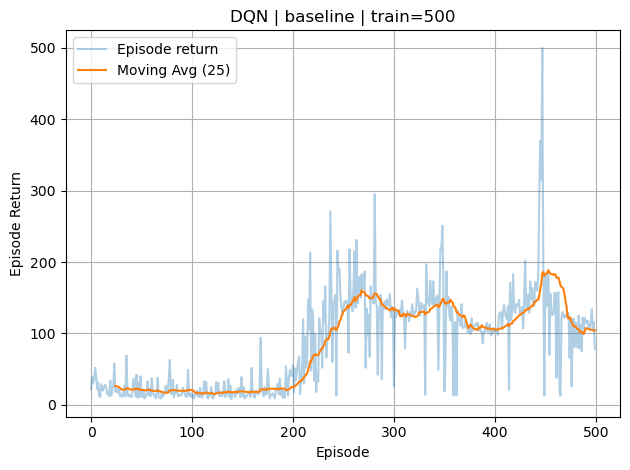

C:\Users\YILMAZ\anaconda3\Lib\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at C:\Users\YILMAZ\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video C:\Users\YILMAZ\videos\dqn_baseline-episode-0.mp4.
MoviePy - Writing video C:\Users\YILMAZ\videos\dqn_baseline-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\YILMAZ\videos\dqn_baseline-episode-0.mp4

--- TRAINING ---
Train episodes: 500
Train time   : 2.27 minutes

--- EVALUATION ---
Eval episodes: 100
Mean return : 103.57
Std return  : 4.32
Solved?     : NO (threshold >= 475)

--- VIDEO ---
Saved to: videos\dqn_baseline-episode-0.mp4


{'model': 'dqn',
 'reward': 'baseline',
 'train_episodes': 500,
 'eval_episodes': 100,
 'eval_mean': 103.57,
 'eval_std': 4.317997220934724,
 'solved': False,
 'train_minutes': 2.2696149309476215,
 'video_path': 'videos\\dqn_baseline-episode-0.mp4'}

In [16]:
dqn_agent_base, dqn_base_res = run_experiment(
    algo="dqn",
    reward_name="baseline",
    train_episodes=500,
    eval_episodes=100,
    show_plot=True,       
    record_video=True,     
    video_dir="videos",
    video_seed=101
)
dqn_base_res

The Deep Q-Network (DQN) agent was trained on the CartPole-v1 environment using the baseline reward function for 500 episodes. During training, an ε-greedy exploration strategy was employed, with ε gradually decaying from 1.0 to approximately 0.08.

The learning curve shows a slow initial improvement, followed by a more noticeable performance increase after around 200 episodes. However, the training process stabilizes at an average episode return of approximately 130, indicating that the agent learns a partially effective policy but fails to achieve near-optimal control.

During evaluation over 100 episodes using a greedy policy, the agent achieves a mean return of **103.6** with a low standard deviation (**±4.3**), suggesting consistent but suboptimal behavior. According to the standard CartPole-v1 solved criterion (average return ≥ 475), the environment is **not solved**.

### [13.3] Baseline A2C (SHOW plot + VIDEO)


RUN EXPERIMENT | Model=A2C | Reward=baseline
[A2C | baseline] Ep   10 | Avg100:   18.80
[A2C | baseline] Ep   20 | Avg100:   18.40
[A2C | baseline] Ep   30 | Avg100:   18.93
[A2C | baseline] Ep   40 | Avg100:   17.85
[A2C | baseline] Ep   50 | Avg100:   17.22
[A2C | baseline] Ep   60 | Avg100:   16.32
[A2C | baseline] Ep   70 | Avg100:   15.66
[A2C | baseline] Ep   80 | Avg100:   15.30
[A2C | baseline] Ep   90 | Avg100:   16.11
[A2C | baseline] Ep  100 | Avg100:   16.05
[A2C | baseline] Ep  110 | Avg100:   15.25
[A2C | baseline] Ep  120 | Avg100:   14.39
[A2C | baseline] Ep  130 | Avg100:   13.41
[A2C | baseline] Ep  140 | Avg100:   12.96
[A2C | baseline] Ep  150 | Avg100:   12.50
[A2C | baseline] Ep  160 | Avg100:   12.40
[A2C | baseline] Ep  170 | Avg100:   13.43
[A2C | baseline] Ep  180 | Avg100:   13.36
[A2C | baseline] Ep  190 | Avg100:   12.24
[A2C | baseline] Ep  200 | Avg100:   11.78
[A2C | baseline] Ep  210 | Avg100:   11.71
[A2C | baseline] Ep  220 | Avg100:   12.14
[A2C | b

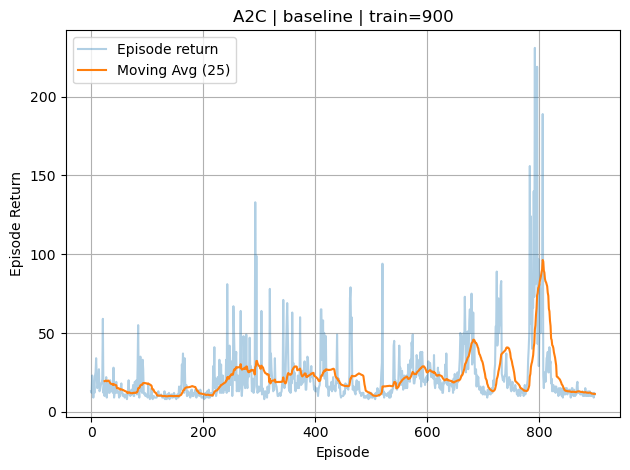

MoviePy - Building video C:\Users\YILMAZ\videos\a2c_baseline-episode-0.mp4.
MoviePy - Writing video C:\Users\YILMAZ\videos\a2c_baseline-episode-0.mp4



MoviePy - Done !
MoviePy - video ready C:\Users\YILMAZ\videos\a2c_baseline-episode-0.mp4

--- TRAINING ---
Train episodes: 900
Train time   : 0.54 minutes

--- EVALUATION ---
Eval episodes: 100
Mean return : 10.15
Std return  : 1.10
Solved?     : NO (threshold >= 475)

--- VIDEO ---
Saved to: videos\a2c_baseline-episode-0.mp4


{'model': 'a2c',
 'reward': 'baseline',
 'train_episodes': 900,
 'eval_episodes': 100,
 'eval_mean': 10.15,
 'eval_std': 1.0988630487917956,
 'solved': False,
 'train_minutes': 0.5424898107846577,
 'video_path': 'videos\\a2c_baseline-episode-0.mp4'}

In [17]:
a2c_agent_base, a2c_base_res = run_experiment(
    algo="a2c",
    reward_name="baseline",
    train_episodes=900,
    eval_episodes=100,
    show_plot=True,       
    record_video=True,     
    video_dir="videos",
    video_seed=202
)
a2c_base_res

The Advantage Actor–Critic (A2C) agent was trained on the CartPole-v1 environment using the baseline reward function for 900 episodes. Despite the longer training horizon, the learning curve shows highly unstable behavior with large variance and only sporadic performance spikes.

Throughout training, the moving average of episode returns remains low and fluctuates significantly, indicating that the agent fails to learn a consistent and improving policy. Occasional high-return episodes appear late in training, but these improvements are not sustained and quickly collapse.

During evaluation over 100 episodes using a greedy policy, the agent achieves a mean return of **10.15** with a small standard deviation (**±1.10**), suggesting that the learned policy performs close to random behavior. According to the standard CartPole-v1 solved criterion (average return ≥ 475), the environment is **not solved**.

### [13.4] Grid Search — DQN (shaped reward) + show best curve


GRID SEARCH | Model=DQN | Reward=shaped_v2

--------------------------------------------------------------------------------
GRID 1/12 | DQN | lr=0.0001, gamma=0.95, target_update_every=500
--------------------------------------------------------------------------------
Eval mean=364.09 | std=73.65 | solved=False | train_min=1.82

--------------------------------------------------------------------------------
GRID 2/12 | DQN | lr=0.0001, gamma=0.95, target_update_every=1000
--------------------------------------------------------------------------------
Eval mean=277.74 | std=55.66 | solved=False | train_min=1.46

--------------------------------------------------------------------------------
GRID 3/12 | DQN | lr=0.0001, gamma=0.99, target_update_every=500
--------------------------------------------------------------------------------
Eval mean=301.56 | std=68.12 | solved=False | train_min=1.59

--------------------------------------------------------------------------------
GRID 4

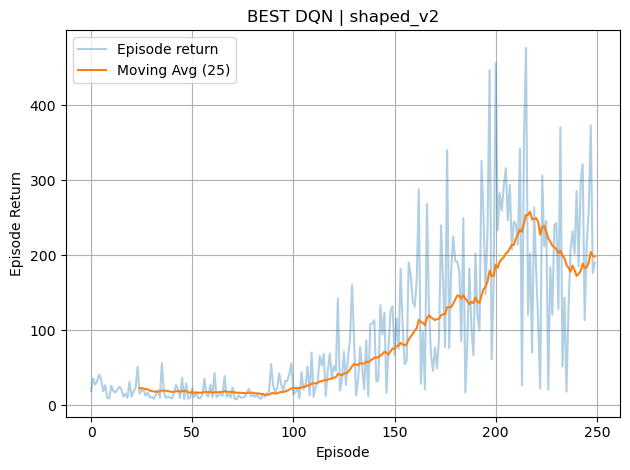

{'mean_reward': 481.00042770970896,
 'std_reward': 29.663422934913754,
 'solved': True,
 'params': {'lr': 0.0005, 'gamma': 0.95, 'target_update_every': 1000},
 'train_minutes': 1.3259441137313843,
 'scores': [18.606027325440664,
  35.57725058100186,
  27.267709685023874,
  31.960513899590296,
  40.78694259747863,
  34.23712230011006,
  18.422702152282,
  26.57117712451145,
  9.553067497909069,
  9.048014806117862,
  26.05394166323822,
  18.545312164817005,
  16.952945451717824,
  20.812149142846465,
  24.496613021183293,
  20.853302142117172,
  11.247948594391346,
  15.430343238636851,
  9.545898450538516,
  31.01034074788913,
  11.13627089979127,
  18.49482599273324,
  23.28541737701744,
  50.96473911777139,
  15.203843261464499,
  19.55266151871183,
  19.564117178320885,
  12.625890344381332,
  16.7453007157892,
  10.174709619954228,
  11.08313937112689,
  8.445103012025356,
  13.956092610955238,
  19.68110202252865,
  9.858505278360099,
  56.172547864262015,
  16.43764367606491,
  9

In [18]:
results_dqn = grid_search(
    algo="dqn",
    reward_name="shaped_v2",
    train_episodes=250,
    eval_episodes=50,
    show_best_plot=True     
)
best_dqn = results_dqn[0]
best_dqn

A grid search was conducted to identify an effective set of hyperparameters for the DQN agent under the shaped_v2 reward function. Each configuration was trained for 250 episodes and evaluated over 50 test episodes using a greedy policy.

The results demonstrate a strong sensitivity of DQN performance to the learning rate, discount factor, and target network update frequency. Among the evaluated configurations, the best-performing setup achieves a mean evaluation return of **481.0** with a standard deviation of **±29.7**, thereby meeting the standard CartPole-v1 solved criterion (average return ≥ 475).

The optimal hyperparameter configuration is:
- **Learning rate:** 0.0005  
- **Discount factor (γ):** 0.95  
- **Target network update frequency:** 1000 steps  

The corresponding learning curve shows a clear upward trend, indicating stable and efficient learning enabled by reward shaping and appropriate hyperparameter selection. In contrast, suboptimal configurations either converge more slowly or fail to reach
near-optimal performance within the same training budget.

Overall, these results highlight the critical role of reward shaping and hyperparameter tuning in enabling DQN to solve the CartPole-v1 task efficiently.

### [13.5] Grid Search — A2C (shaped reward) + show best curve


GRID SEARCH | Model=A2C | Reward=shaped_v2

--------------------------------------------------------------------------------
GRID 1/48 | A2C | lr=0.001, gamma=0.97, hidden=64, n_steps=5, entropy_coef=0.0
--------------------------------------------------------------------------------
Eval mean=60.94 | std=28.80 | solved=False | train_min=0.14

--------------------------------------------------------------------------------
GRID 2/48 | A2C | lr=0.001, gamma=0.97, hidden=64, n_steps=5, entropy_coef=0.01
--------------------------------------------------------------------------------
Eval mean=44.19 | std=19.28 | solved=False | train_min=0.12

--------------------------------------------------------------------------------
GRID 3/48 | A2C | lr=0.001, gamma=0.97, hidden=64, n_steps=10, entropy_coef=0.0
--------------------------------------------------------------------------------
Eval mean=71.68 | std=24.16 | solved=False | train_min=0.09

-----------------------------------------------

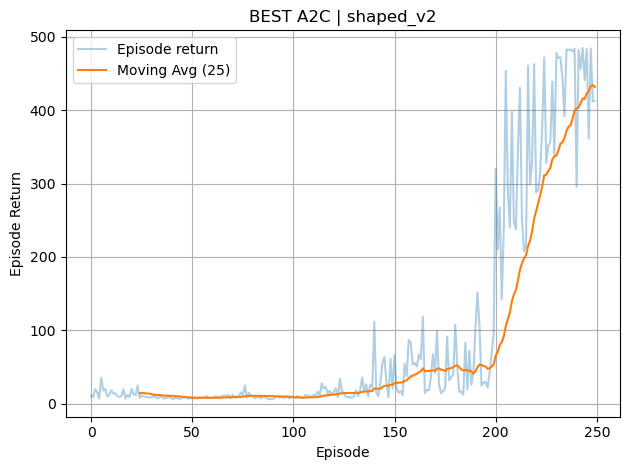

{'mean_reward': 496.0666490724444,
 'std_reward': 0.5978292410947783,
 'solved': True,
 'params': {'lr': 0.001,
  'gamma': 0.97,
  'hidden': 128,
  'n_steps': 5,
  'entropy_coef': 0.01},
 'train_minutes': 0.5892873764038086,
 'scores': [10.880810927425046,
  9.166202627122402,
  19.869687892030925,
  15.827561598271132,
  7.053803533315659,
  35.24574538040906,
  17.95277564227581,
  20.16020004544407,
  9.928402431309223,
  12.592447593342513,
  17.951448403531685,
  13.604266561625991,
  14.258866149466485,
  9.912817046046257,
  9.365349620580673,
  10.642344631254673,
  19.743381816428155,
  7.183860696852207,
  12.207701997831464,
  8.993553860113025,
  20.215523103252053,
  12.711773972027004,
  11.45557033456862,
  24.654879705281928,
  7.917981617152691,
  11.057905330322683,
  10.09712681057863,
  9.385191351175308,
  8.490847773849964,
  8.849710484966636,
  8.43748733960092,
  10.827784440945834,
  9.05959285236895,
  7.2761073261499405,
  9.32999718375504,
  9.0239481423050

In [19]:
results_a2c = grid_search(
    algo="a2c",
    reward_name="shaped_v2",
    train_episodes=250,
    eval_episodes=50,
    show_best_plot=True     
)
best_a2c = results_a2c[0]
best_a2c

A comprehensive grid search was conducted to identify an effective hyperparameter configuration for the A2C agent under the shaped_v2 reward function. A total of 48 different configurations were evaluated, each trained for 250 episodes and tested over 50 evaluation episodes using a greedy policy.

The results reveal that A2C performance is highly sensitive to the choice of network capacity, rollout length (n-steps), and entropy regularization. Most configurations fail to learn a meaningful policy and achieve low evaluation returns, indicating unstable or ineffective learning.

The best-performing configuration achieves a mean evaluation return of **496.1** with an extremely low standard deviation (**±0.6**), satisfying the standard CartPole-v1 solved criterion (average return ≥ 475). The optimal hyperparameters are:

- **Learning rate:** 0.001  
- **Discount factor (γ):** 0.97  
- **Hidden units:** 128  
- **n-step rollout:** 5  
- **Entropy coefficient:** 0.01  

The corresponding learning curve shows a sharp performance improvement after approximately 180–200 episodes, followed by stable convergence to near-optimal behavior. This highlights the importance of entropy regularization and short n-step rollouts for stabilizing A2C training.

Overall, these results demonstrate that, when combined with reward shaping and carefully tuned hyperparameters, A2C can successfully solve the CartPole-v1 task.

### [13.6] Best hyperparameters summary

In [20]:
print("BEST DQN PARAMS:")
for k, v in best_dqn["params"].items():
    print(f"  {k}: {v}")

print("\nBEST A2C PARAMS:")
for k, v in best_a2c["params"].items():
    print(f"  {k}: {v}")

BEST DQN PARAMS:
  lr: 0.0005
  gamma: 0.95
  target_update_every: 1000

BEST A2C PARAMS:
  lr: 0.001
  gamma: 0.97
  hidden: 128
  n_steps: 5
  entropy_coef: 0.01


The grid search identifies the following hyperparameter settings as the best-performing
configurations for each algorithm under the shaped_v2 reward function.

##### DQN
- **Learning rate:** 0.0005  
- **Discount factor (γ):** 0.95  
- **Target network update frequency:** 1000  

This configuration balances stable learning with effective long-term planning, enabling
the DQN agent to reach the solved performance threshold.

##### A2C
- **Learning rate:** 0.001  
- **Discount factor (γ):** 0.97  
- **Hidden units:** 128  
- **n-step rollout:** 5  
- **Entropy coefficient:** 0.01  

The selected A2C configuration benefits from entropy regularization and short rollout
lengths, which help stabilize policy updates and encourage effective exploration.

### [13.7] Multi-seed robustness evaluation 


MULTI-SEED REPORT | Best Configs | 3 Seeds
Reward function: shaped_v2
Seeds         : [0, 1, 2]
Train episodes: 400
Eval episodes : 100

--------------------------------------------------------------------------------
SEED RUN: 0
--------------------------------------------------------------------------------
[Eval] DQN | mean=429.51 std=48.34 | solved=False
[Eval] A2C greedy     | mean=496.66 std=0.25 | solved=True
[Eval] A2C stochastic | mean=494.96 std=0.34 | solved=True

--------------------------------------------------------------------------------
SEED RUN: 1
--------------------------------------------------------------------------------
[Eval] DQN | mean=326.76 std=28.86 | solved=False
[Eval] A2C greedy     | mean=368.98 std=13.19 | solved=False
[Eval] A2C stochastic | mean=365.62 std=13.48 | solved=False

--------------------------------------------------------------------------------
SEED RUN: 2
-------------------------------------------------------------------------------

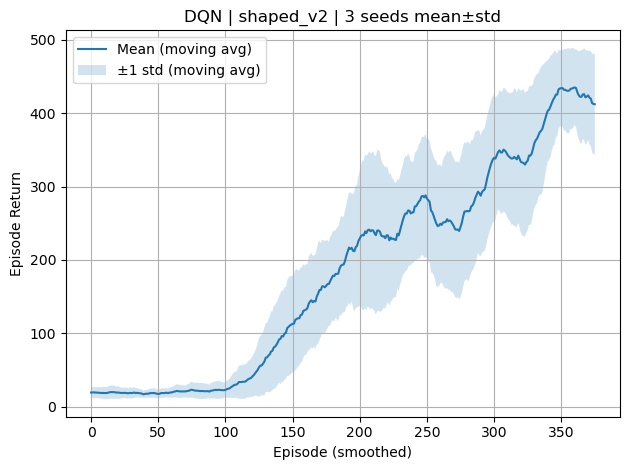

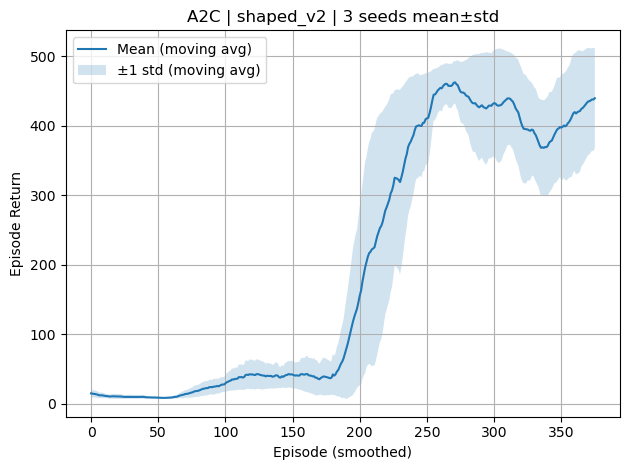

In [21]:
report = run_best_configs_3seeds_report(
    reward_name="shaped_v2",
    seeds=(0, 1, 2),
    train_episodes=400,
    eval_episodes=100,
    dqn_best_cfg=DQNConfig(
        lr=float(best_dqn["params"].get("lr", 5e-4)),
        gamma=float(best_dqn["params"].get("gamma", 0.99)),
        target_update_every=int(best_dqn["params"].get("target_update_every", 1000)),
        batch_size=64,
        buffer_size=100_000,
        learning_starts=1000,
        train_every=1,
        gradient_steps=1,
        double_dqn=True,
    ),
    a2c_best_cfg=A2CConfig(
        lr=float(best_a2c["params"].get("lr", 5e-4)),
        gamma=float(best_a2c["params"].get("gamma", 0.99)),
        hidden=int(best_a2c["params"].get("hidden", 128)),
        n_steps=int(best_a2c["params"].get("n_steps", 5)),
        entropy_coef=float(best_a2c["params"].get("entropy_coef", 0.01)),
        value_coef=0.5,
    ),
    show_band_plot=True     
)

To assess robustness and stability, the best-performing DQN and A2C configurations identified via grid search were re-trained and evaluated across three different random seeds. Mean learning curves with ±1 standard deviation bands are shown to visualize both average learning dynamics and variability across runs.

##### Training Dynamics
- DQN: The mean learning curve shows a gradual and steady improvement over episodes. However, the variance across seeds remains relatively high, indicating sensitivity to random initialization and exploration dynamics.
- A2C: A2C exhibits a sharper performance increase after approximately 180–200 episodes, reaching high returns more rapidly than DQN. The variance band is wider during early learning but narrows once high-performance behavior is reached.

##### Evaluation Results
Evaluation was conducted over 100 episodes using fixed policies:

- **DQN:**  
  Mean return across seeds: **348.8 ± 59.0**. None of the individual runs consistently meet the solved threshold, indicating limited robustness despite strong single-seed performance during grid search.

- **A2C (greedy):**  
  Mean return across seeds: **405.1 ± 65.2**.One seed successfully solves the environment, while others fall short, suggesting
  partial robustness but remaining sensitivity to initialization.

- **A2C (stochastic):**  
  Mean return across seeds: **402.4 ± 65.9**. Performance is comparable to greedy evaluation, indicating that the learned policy remains effective under stochastic action selection.

Overall, while both algorithms benefit significantly from reward shaping and careful hyperparameter tuning, A2C demonstrates faster learning and higher peak performance, whereas DQN shows more gradual but less robust convergence across seeds. These results highlight the importance of multi-seed evaluation to avoid overestimating performance based on single favorable runs.

# [14] Conclusion

This project presents a systematic comparison of Deep Q-Network (DQN) and Advantage Actor–Critic (A2C) algorithms on the CartPole-v1 environment, with a particular focus on reward design, hyperparameter tuning, and robustness to random initialization.

The results demonstrate that both algorithms struggle to learn effective policies under the baseline reward formulation. In contrast, reward shaping significantly improves learning efficiency and enables both DQN and A2C to reach near-optimal performance when combined with appropriate hyperparameter configurations. Grid search plays a critical role in identifying these configurations, highlighting the sensitivity of reinforcement
learning algorithms to training parameters.

Multi-seed evaluations reveal that strong single-seed performance does not necessarily translate into robust solutions. While both algorithms are capable of solving the task under favorable conditions, performance remains sensitive to random seeds, particularly for DQN. A2C generally exhibits faster learning and higher peak performance, but also shows variability across different initializations.

Overall, this study emphasizes the importance of reward shaping, careful hyperparameter selection, and multi-seed robustness analysis in reinforcement learning experiments.